# Customer Segmentation 

This notebook will focus on the creation, deployment, 
monitoring and management of a machine learning model for performing 
customer segmentation. 

We will be using an e-commerce dataset detailing actual purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). 

In this notebook we will: 

- Explore a subset of the dataset
- Train several models on the pre-processed dataset
- Deploy trained models to Seldon 
- Train an anchor tabular explainer and update Seldon deployment with explainer
- Train an outlier detector (variational autoencoder) and update deployment 

### Prerequisites
Initially, we install some additional packages which do not come out of the box with our Colab environment, and then import all of the relevant packages. 

In [51]:
!pip install seldon-deploy-sdk==1.5.0
!pip install alibi==0.6.4
!pip install alibi-detect==0.8.1
!pip install fsspec
!pip install gcsfs
!pip install dill

  Using cached alibi-0.6.4-py3-none-any.whl (397 kB)
  Attempting uninstall: alibi
    Found existing installation: alibi 0.6.0
    Uninstalling alibi-0.6.0:
      Successfully uninstalled alibi-0.6.0
  Using cached alibi_detect-0.8.1-py3-none-any.whl (311 kB)
  Attempting uninstall: alibi-detect
    Found existing installation: alibi-detect 0.9.1
    Uninstalling alibi-detect-0.9.1:
      Successfully uninstalled alibi-detect-0.9.1


In [26]:
import json
import pprint
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import pickle 
import joblib
import dill
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, InputLayer
from alibi.explainers import AnchorTabular
from alibi_detect.datasets import fetch_kdd
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.cd import TabularDrift
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular, plot_roc
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi, PredictApi
from seldon_deploy_sdk.auth import OIDCAuthenticator
from seldon_deploy_sdk.rest import ApiException



We then download our pre-processed dataset to save time in getting to the exciting parts:

In [2]:
!gsutil -m cp -r gs://tom-seldon-examples/retail-workshop/data .



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://tom-seldon-examples/retail-workshop/data/X_test.npy...
Copying gs://tom-seldon-examples/retail-workshop/data/Y_test.npy...             
Copying gs://tom-seldon-examples/retail-workshop/data/X_train.npy...
Copying gs://tom-seldon-examples/retail-workshop/data/Y_train.npy...
Copying gs://tom-seldon-examples/retail-workshop/data/data.csv...               
\ [5/5 files][ 43.1 MiB/ 43.1 MiB] 100% Done                                    
Operation completed over 5 objects/43.1 MiB.                                  

### Data Exploration

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has curated a retail dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail". The following description is provided via Kaggle: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

We will first explore the dataset and then train models on a pre-processed version of the dataset that was transformed through following the fantastic work of Fabien Daniel whose methods are detailed in [this notebook](https://www.kaggle.com/fabiendaniel/customer-segmentation).

Lets dive in and explore a subset of the dataset:

In [3]:
df_initial = pd.read_csv('data/data.csv', encoding="ISO-8859-1", nrows=3000,
                         dtype={'CustomerID': str,'InvoiceID': str})

print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (3000, 8)


In [4]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

# show first lines
display(df_initial[:5])

/var/folders/xv/n51qjph14_52lj9y4706w6sc0000gn/T/ipykernel_10149/1852387864.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
/var/folders/xv/n51qjph14_52lj9y4706w6sc0000gn/T/ipykernel_10149/1852387864.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,10,0,0,0,1081,0
null values (%),0.0,0.0,0.333333,0.0,0.0,0.0,36.033333,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


The dataset contains the following features: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description**: Product (item) name. Nominal.

**Quantity**: The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country**: Country name. Nominal, the name of the country where each customer resides.

As you can see, there are all kinds of weird and wonderful products being purchased:

![](https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/tacky_waterbottle.jpg "KNITTED UNION FLAG HOT WATER BOTTLE")


We will be training models using a transformed version of this dataset. Rather than detailing each individual item bought, the transformed dataset details the spending behavoir of each individual customer across different categories of products. We don't have any product categories in the original dataset so we create this feature through analysing keywords used within product descriptions and applying k-means clustering to create a finite number of product clusters. We find in our analysis that 5 clusters is a suitable number to seperate products without creating clusters containing too few products (calculated using silhouette score). The following wordclouds demonstrate the splits we generate:

<img src="https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/download.png">

We see that cluster no1 contains words we might associate more with gifts ('christmas', 'card', 'wrap', 'decoration') and no3 more with luxury goods ('lace', 'necklace'), although some of the other clusters are less differentiated.

Based on customer spending across each of these categories of product, we can similarly use k-means to cluster customers into different segments. Performing similar analysis to how we clustered product categories, we find 11 clusters is the most suitable for segmenting customers within this dataset.

# Split the Data

In [5]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ] # change to feature_names?
class_names = ['0','1','2','3','4','5','6','7','8','9','10']
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')
X_test = np.load('data/X_test.npy')
Y_test = np.load('data/Y_test.npy')

The transformed dataset contains the following features specific to each unique customer:

**mean**: mean spend across all transactions

**categ_0**: percentage of total spend on products within category 0

**categ_1**: percentage of total spend on products within category 1

**categ_2**: percentage of total spend on products within category 2

**categ_3**: percentage of total spend on products within category 3

**categ_4**: percentage of total spend on products within category 4

**customer_category**: integer signifying which of the 11 categories the customer aligns most with

In [6]:
customers = pd.DataFrame(Y_train, columns=['customer_category']).astype(dtype=int)
spending = pd.DataFrame(X_train, columns = columns)
transformed_dataset = pd.concat([spending, customers], axis=1)
transformed_dataset

,mean,categ_0,categ_1,categ_2,categ_3,categ_4,customer_category
0,200.565000,43.015980,11.816618,34.352953,3.814225,7.000224,9
1,220.310000,5.617085,23.864101,10.576007,6.944760,52.998048,2
2,166.711667,24.618353,20.467474,20.624431,31.508493,2.781249,6
3,232.295000,13.323576,39.856648,11.989066,23.009535,11.821176,6
4,139.870000,32.735755,17.559162,29.033209,16.398263,4.273611,6
...,...,...,...,...,...,...,...
2881,674.263333,15.985841,28.804275,26.545020,15.703558,12.961306,6
2882,406.020000,11.871336,17.999113,27.880400,36.485887,5.763263,6
2883,194.115000,16.652500,15.403240,0.000000,37.652938,30.291322,6
2884,145.617500,27.349048,27.055471,17.588889,19.528903,8.477690,6


We can explore the range of values across each of the features within our dataset:

In [7]:
transformed_dataset.max(axis=0)

mean                 12425.45
categ_0                100.00
categ_1                100.00
categ_2                100.00
categ_3                100.00
categ_4                100.00
customer_category       10.00
dtype: float64

In [8]:
transformed_dataset.min(axis=0)

mean                 2.9
categ_0              0.0
categ_1              0.0
categ_2              0.0
categ_3              0.0
categ_4              0.0
customer_category    0.0
dtype: float64

## Model Training

In this section we will adjust a classifier that will classify consumers in the different client categories. 

In [9]:
# Standardise the dataset
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / stdev
X_test = (X_test - mean) / stdev

### Logistic Regression

In [10]:
lr = linear_model.LogisticRegression(max_iter=4000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=4000)

In [11]:
accuracy_score(Y_test, lr.predict(X_test))

0.9182825484764543

### Gradient Boosting Classifier 

In [12]:
gb=ensemble.GradientBoostingClassifier()
gb.fit(X = X_train, y = Y_train)

GradientBoostingClassifier()

In [13]:
accuracy_score(Y_test, gb.predict(X_test))

0.8933518005540166

In [14]:
models = ['lr', 'gb']

for model in models:
    if not os.path.exists('models/' + model):
        os.makedirs('models/' + model)

In [15]:
filename = 'models/lr/model.joblib'
joblib.dump(lr, filename)

['models/lr/model.joblib']

In [16]:
filename = 'models/gb/model.joblib'
joblib.dump(gb, filename)

['models/gb/model.joblib']

### Push model artefacts to GCP

To push models to GCP you will create a unique folder with your name. Uncomment the command and replace "YOUR NAME" with your name.

In [39]:
!gsutil cp models/lr/model.joblib gs://tom-seldon-examples/retail-workshop/models/<YOUR-NAME>/lr/model.joblib
!gsutil cp models/gb/model.joblib gs://tom-seldon-examples/retail-workshop/models/<YOUR-NAME>/gb/model.joblib

zsh:1: no such file or directory: YOUR-NAME
zsh:1: no such file or directory: YOUR-NAME


### Deploy models to Seldon

We can now deploy our model to the dedicated Seldon Deploy cluster which we have configured for this workshop. To do so we will interact with the Seldon Deploy SDK.

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the SD_IP variable to be the same as the cluster you are using.

In [18]:
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator
SD_IP = "35.196.185.135"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = 'client_credentials'
config.verify_ssl = False

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now we have configured the IP correctly as well as setup our authentication function we can desrcibe the deployment we would like to create.

You will need to fill in the DEPLOYMENT_NAME, NAMESPACE, and the MODEL_LOCATION, the rest of the deployment description has been templated for you.

You will need to create a unique deployment name. A good example format would be "YOUR NAME" + "MODEL" so "sgreaves-lr" in my case (be careful not to use any upper-case letters or other characters like "_". 

For the Model location we will be using a pre-trained model so no changes necessary to that URL.

In [19]:
YOUR_NAME = "josh"
MODEL_NAME = "lr-2"

DEPLOYMENT_NAME = f"{YOUR_NAME}-{MODEL_NAME}"
MODEL_LOCATION = f"gs://tom-seldon-examples/retail-workshop/models/josh/lr"

In [20]:
NAMESPACE = "seldon-demos"

PREPACKAGED_SERVER = "SKLEARN_SERVER"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

We can now invoke the `SeldonDeploymentsApi` and create a new Seldon Deployment. 

Time for you to get your hands dirty. You will use the Seldon Deploy SDK to create a new Seldon deployment. You can find the reference documentation [here](https://github.com/SeldonIO/seldon-deploy-sdk/blob/master/python/README.md). 

In [21]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'josh-lr-2',
              'namespace': 'seldon-demos',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'josh-lr-2',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
            

Our model should now be running as a fully fledged microservice. We can now log into Seldon Deploy and test our deployment: 

* URL: http://35.196.185.135/seldon-deploy/


You can make a prediction using the PredictAPI of the Seldon Deploy SDK

In [29]:
predict_api = PredictApi(auth())
namespace = 'seldon-demos' # str | Namespace provides a logical grouping of resources
prediction = {"data": {"ndarray": [[-0.43831067,  0.23457404, -0.17366155,  0.26935668,  0.13463672, -0.55234561]]}}

try:
    api_response = predict_api.predict_seldon_deployment(DEPLOYMENT_NAME, namespace, prediction)
    pprint.pprint(api_response)
except ApiException as e:
    print("Exception when calling PredictApi->predict_seldon_deployment: %s\n" % e)

{'data': {'names': ['t:0',
                    't:1',
                    't:2',
                    't:3',
                    't:4',
                    't:5',
                    't:6',
                    't:7',
                    't:8',
                    't:9',
                    't:10'],
          'ndarray': [[0.002059939420558877,
                       0.0018341464883069975,
                       5.929830502754066e-07,
                       0.014462211013891082,
                       0.004063082869132578,
                       7.485905615355247e-07,
                       0.9402590016909633,
                       8.643533977369213e-05,
                       2.3670617247707977e-06,
                       0.0013547531011716095,
                       0.035876721440865254]]},
 'meta': {'requestPath': {'josh-lr-2-container': 'seldonio/sklearnserver:1.13.1'}}}


### Model wrapping (aside)

To deploy our models we didn't need to build a server as there already exists containers for serving scikit-learn and xgboost models that we could use when defining `implementation` within our inference graph. This will not always be the case and we will often need to build our own server. Seldon Core can be used to server models based in Python, Java, R, Node and Go. We can use Seldon Core to build two kinds of server, reusable and non-reusable: 

![](https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/servers.png "Reusable and non-reusable servers")

Reusable servers allow us to provide a `model uri` parameter so we can serve different models every time we deploy without needing to build a new server. Non-reusable servers wrap models within the container and so if we want to deploy a new model, we need to build a new server.

The process for wrapping python models in a non-reusable server is covered within the [Seldon Core documentation](https://docs.seldon.io/projects/seldon-core/en/latest/python/index.html) and within this [simple guide](https://docs.google.com/presentation/d/1wzs_Xfw0iGXYvPkas9VWO4cvW6xvtwHeNclw0m9ej0M/edit?usp=sharing) for wrapping a scikit-learn model trained on the iris dataset. Included within the `wrapper` directory in this repo are the files required to wrap an example model: 

- model class (CustomSegmenter.py)
- model artefact (models/lr/model.joblib)
- dependencies (requirements.txt)
- environment (.s2i/environment)
- optional testing scripts (test.py & container_test.py)

You can have a go at wrapping the model stored within the `wrapper` directory by installing the [Source-2-Image tool](https://github.com/openshift/source-to-image) and running the following command within the wrapper directory to build a container: 

`s2i build . seldonio/seldon-core-s2i-python3:1.12.0-dev customer-segmenter:0.1`

## Explainer

Next, we shall train an explainer to glean deeper insights into the decisions being made by our model. We will make use of the Anchors algorithm, which has a [production grade implementation available](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) using the Seldon Alibi Explain library. 

The algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Anchor algorithms incorporate coverage, which is the region the explanation applies within and are optimised to maximize coverage.

As an example of anchors for tabular data, if we want to predict whether a person makes less or more than £50,000 per year based on the person’s characteristics including age (continuous variable) and marital status (categorical variable), then the following would be a potential anchor: Hugo makes more than £50,000 because he is married and his age is between 35 and 45 years.

The first step will be to write a simple prediction function which the explainer can call in order to query our logistic regression model.

In [30]:
predict_fn = lambda x: lr.predict(x)

We then initialise our Anchor explainer, using the AnchorTabular flavour provided by Alibi due to our data modality.

In [31]:
explainer = AnchorTabular(predict_fn, columns)

We will now train our explainer. We need to specify percentages that our model will use to discretize continuous numerical data into intervals. Generally we observe that if we choose smaller percentages (finer discretization), this will lead to longer runtime and potentially higher precision. 

In [32]:
explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.6.4'}
)

We can now test our explainer by generating a prediction.

In [33]:
idx = 0
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

Prediction:  6


In [34]:
explanation = explainer.explain(X_test[idx], threshold=0.9)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: categ_2 <= 0.45 AND -0.17 < categ_0 <= 0.44 AND mean <= 0.09 AND categ_1 <= 0.47 AND categ_3 <= 0.44
Precision: 0.94
Coverage: 0.06


We use dill to serialise our explainer:

In [35]:
explainer.save("explainer")

We will not push our explainer to GCP as explainer files can be quite large (100MB+) so instead we will deploy a pretrained explainer!


## Deployment

We can now deploy an explainer alongside our model:

In [13]:
!gsutil cp -r explainer gs://tom-seldon-examples/retail-workshop/models/<Insert Name Here>/lr/explainer2

Copying file://explainer/explainer.dill [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://explainer/meta.dill [Content-Type=application/octet-stream]...   
- [2 files][151.7 MiB/151.7 MiB]    3.8 MiB/s                                   
Operation completed over 2 objects/151.7 MiB.                        

Once again we will use a pretrain explainer that is already in google storage to add the explainer to our deployments

In [36]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = "gs://tom-seldon-examples/retail-workshop/models/josh/lr/explainer2"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

In [37]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

{'kind': 'SeldonDeployment',
 'metadata': {'name': 'josh-lr-2',
  'namespace': 'seldon-demos',
  'labels': {'fluentd': 'true'}},
 'apiVersion': 'machinelearning.seldon.io/v1alpha2',
 'spec': {'name': 'josh-lr-2',
  'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
  'protocol': 'seldon',
  'transport': 'rest',
  'predictors': [{'componentSpecs': [{'spec': {'containers': [{'name': 'josh-lr-2-container',
         'resources': {'requests': {'cpu': '0.1', 'memory': '1Gi'},
          'limits': {'cpu': '0.1', 'memory': '1Gi'}}}]}}],
    'name': 'default',
    'replicas': 1,
    'traffic': 100,
    'graph': {'implementation': 'SKLEARN_SERVER',
     'modelUri': 'gs://tom-seldon-examples/retail-workshop/models/josh/lr',
     'name': 'josh-lr-2-container',
     'endpoint': {'type': 'REST'},
     'parameters': [],
     'children': [],
     'logger': {'mode': 'all'}},
    'explainer': {'type': 'AnchorTabular',
     'modelUri': 'gs://tom-seldon-examples/retail-workshop/mod

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

## Outlier Detection
You will now setup your outlier detector. This will pick up anomalous data points in an automated fashion. You will use the Seldon Alibi Detect library to configure a Variational Auto Encoder (VAE) outlier detector.

In this case you are going to assume that any instance which is labelled as customer segmentation cluster 1 is an outlier. Clearly, this is a trivial example, as we are using our model to predict the customer segmen. However it demonstrates the flow of outlier detector creation nicely, and provides a set of easy to identify outliers. 

You now generate a dataset of inliers (all other clusters) and outliers (customer cluster 1). 

In [39]:
df_total = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train, columns=[6])], axis=1)

inliers = df_total[(df_total[6] != 1)]
inliers.drop(labels=6, axis=1, inplace=True)
inliers_np = inliers.to_numpy()

outliers = df_total[df_total[6] == 1]
outliers.drop(labels=6, axis=1, inplace=True)
outliers_np = outliers.to_numpy()

You will then define the architecture of your VAE. The VAE works by attempting to reconstruct the input data which it receives. The VAE first encodes the data in some latent space (in our case a 2 dimensional vector), and then uses a decoder to reconstruct the original input data from the encoding. This forces the VAE to learn a mapping of input data to the latent space, and vice versa. If input data maps poorly to the latent space, and/or maps poorly from latent space to output then it is likely out of the distribution which the VAE was trained upon. Therefore, we can classify it as an outlier.  

![](https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/vae_architecture.png "VAE Architecture")

The first step is to define our VAE architecture. You will use TensorFlow Keras to setup the architecture for your encoder and decoder. 

In [40]:
# define model, initialize, train and save outlier detector
    
n_features = X_train.shape[1]
latent_dim = 2
    
encoder_net = tf.keras.Sequential(
    [
     InputLayer(input_shape=(n_features,)),
     Dense(20, activation=tf.nn.relu),
     Dense(15, activation=tf.nn.relu),
     Dense(7, activation=tf.nn.relu)
     ])

decoder_net = tf.keras.Sequential(
    [
     InputLayer(input_shape=(latent_dim,)),
     Dense(7, activation=tf.nn.relu),
     Dense(15, activation=tf.nn.relu),
     Dense(20, activation=tf.nn.relu),
     Dense(n_features, activation=None)
     ])

Next you will make use of Alibi Detect's OutlierVAE class and instantiate it using the encoder and decoder architecture you defined above. 

You will then call the `fit` method on your outlier detector. To learn how to correctly reconstruct normal data the VAE is fit on only inlier examples initially. In this case you will use your `inliers` set as this does not contain any outlying data points. 

In [41]:
# initialize outlier detector
od = OutlierVAE(threshold=None,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=5) # number of samples drawn during detection for each instance to detect
# train
od.fit(inliers,
       loss_fn=elbo, # Loss function used for training
       cov_elbo=dict(sim=.01), # If using the elbo loss, this is the covariance matrix
       epochs=50,
       verbose=True)

No threshold level set. Need to infer threshold using `infer_threshold`.


42/42 [=] - 1s 28ms/step - loss_ma: 4103.9359


You now need to set the threshold for your outlier detector. This is the score above which any instance will be considered an outlier. 

To do this you can make use of the `infer_threshold` function which Alibi provides. This will take a batch of data with a specified percentage of outliers, you therefore create a function to generate a dataset with a specified percentage of outliers*.

\*Alibi has a comparable function for generating batches of outlier data called `create_outlier_batch` 

In [27]:
def generate_outlier_batch(perc_outlier=5, inliers=inliers, outliers=outliers, n_samples=1000):
    outlier_idx = int(np.round(n_samples * (perc_outlier / 100), 0))
    inlier_idx = int(np.round(n_samples * (1 - perc_outlier / 100), 0))

    outlier_batch = outliers[:outlier_idx]
    inlier_batch = inliers[:inlier_idx]

    y_combined = np.concatenate([np.ones(len(outlier_batch)), np.zeros(len(inlier_batch))]).astype('int32')

    X_combined = np.concatenate((outlier_batch, inlier_batch))
    return X_combined, y_combined

X_threshold, y_threshold = generate_outlier_batch()

Now inferring the threshold. 

In [28]:
perc_outlier = 5
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.7322891824793258


You can now test your threshold by generating a second batch of outlying data, this time with a higher proportion of outliers. 

In [29]:
X_outlier, y_outlier = generate_outlier_batch(perc_outlier=10)
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 6) (1000,)
10.0% outliers


Generating outlier predictions from the new detector using the freshly created outlier batch. 

In [30]:
od_preds = od.predict(X_outlier, return_instance_score=True)

Visualising the effectiveness of our outlier detector using a confusion matrix. 

F1 score: 0.488095238095238


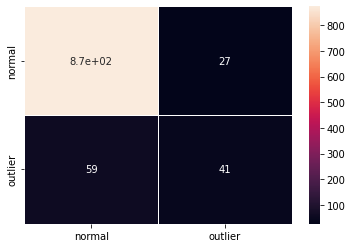

In [31]:
labels = ['normal', 'outlier']

y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))

cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

And then using a scatter plot and ROC curve. 

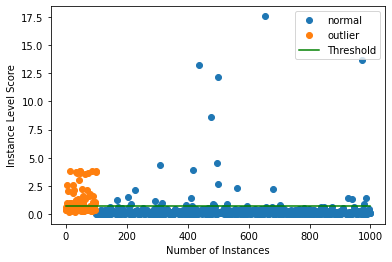

In [32]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

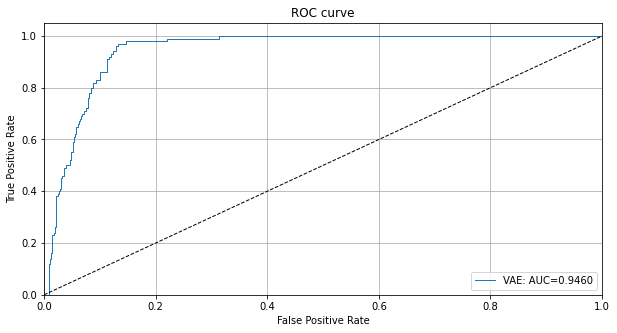

In [33]:
roc_data = {'VAE': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)

You can now save your outlier detector locally, and subsequently push to remote storage. 

In [34]:
save_detector(od, "outlier")

Directory outlier does not exist and is now created.
Directory outlier/model does not exist and is now created.


## Configure in Seldon UI

### URI for Drift Detector
`gs://tom-seldon-examples/retail-workshop/models/josh/outlier`

Using your freshly uploaded outlier detector you can deploy this alongside your model into Seldon Deploy. Once again you will need to replace 'YOUR NAME' so we're saving our file to correct place:

You can now test the outlier detector with the following inlier request:

In [43]:
predict_api = PredictApi(auth())
namespace = 'seldon-demos' # str | Namespace provides a logical grouping of resources
prediction = {"data": {"ndarray": [[-0.43831067,  0.23457404, -0.17366155,  0.26935668,  0.13463672, -0.55234561]]}}

try:
    api_response = predict_api.predict_seldon_deployment(DEPLOYMENT_NAME, namespace, prediction)
    pprint.pprint(api_response)
except ApiException as e:
    print("Exception when calling PredictApi->predict_seldon_deployment: %s\n" % e)

{'data': {'names': ['t:0',
                    't:1',
                    't:2',
                    't:3',
                    't:4',
                    't:5',
                    't:6',
                    't:7',
                    't:8',
                    't:9',
                    't:10'],
          'ndarray': [[0.002059939420558877,
                       0.0018341464883069975,
                       5.929830502754066e-07,
                       0.014462211013891082,
                       0.004063082869132578,
                       7.485905615355247e-07,
                       0.9402590016909633,
                       8.643533977369213e-05,
                       2.3670617247707977e-06,
                       0.0013547531011716095,
                       0.035876721440865254]]},
 'meta': {'requestPath': {'josh-lr-2-container': 'seldonio/sklearnserver:1.13.1'}}}


And then with a massive outlier:

In [42]:
predict_api = PredictApi(auth())
namespace = 'seldon-demos' # str | Namespace provides a logical grouping of resources
prediction = {"data": {"ndarray": [[10,  10, 10,  10,  10, 10]]}}

try:
    api_response = predict_api.predict_seldon_deployment(DEPLOYMENT_NAME, namespace, prediction)
    pprint.pprint(api_response)
except ApiException as e:
    print("Exception when calling PredictApi->predict_seldon_deployment: %s\n" % e)

{'data': {'names': ['t:0',
                    't:1',
                    't:2',
                    't:3',
                    't:4',
                    't:5',
                    't:6',
                    't:7',
                    't:8',
                    't:9',
                    't:10'],
          'ndarray': [[0.02353641808297226,
                       2.2504188329550804e-30,
                       1.3750864301023277e-25,
                       2.8299462438860853e-35,
                       5.4228272475098e-19,
                       0.33706777228831697,
                       5.001605657740339e-20,
                       9.030247045075527e-30,
                       0.6393958095039226,
                       3.4055837605244814e-24,
                       1.2478814507404755e-10]]},
 'meta': {'requestPath': {'josh-lr-2-container': 'seldonio/sklearnserver:1.13.1'}}}
